# Load dataset

In [ ]:
import numpy as np
import pandas as pd

data = pd.read_csv('data.csv')
data.info()
print(data.head())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Pressure (bar)                         992 non-null    int64  
 1   Medium                                 992 non-null    object 
 2   Leak Size (mm)                         992 non-null    float64
 3   P1: Mean Frequency                     992 non-null    float64
 4   P2: Variance                           992 non-null    float64
 5   P3: Skewness                           992 non-null    float64
 6   P4: Spectral Kurtosis                  992 non-null    float64
 7   P5: Centroid Frequency                 992 non-null    float64
 8   P6: Std Dev Centroid Frequency         992 non-null    float64
 9   P7: RMS Frequency                      992 non-null    float64
 10  P8: Fourth Moment of Frequency         992 non-null    float64
 11  P9: Fl

In [ ]:
# Removing outliers
def RemoveOutliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Data cleaning and Exploratory Data Analysis (EDA)
Data is imbalanced on Condition column - will be addressed later on model training using SMOTE

Medium
Oil    992
Name: count, dtype: int64
Condition
Leak      744
Normal    248
Name: count, dtype: int64


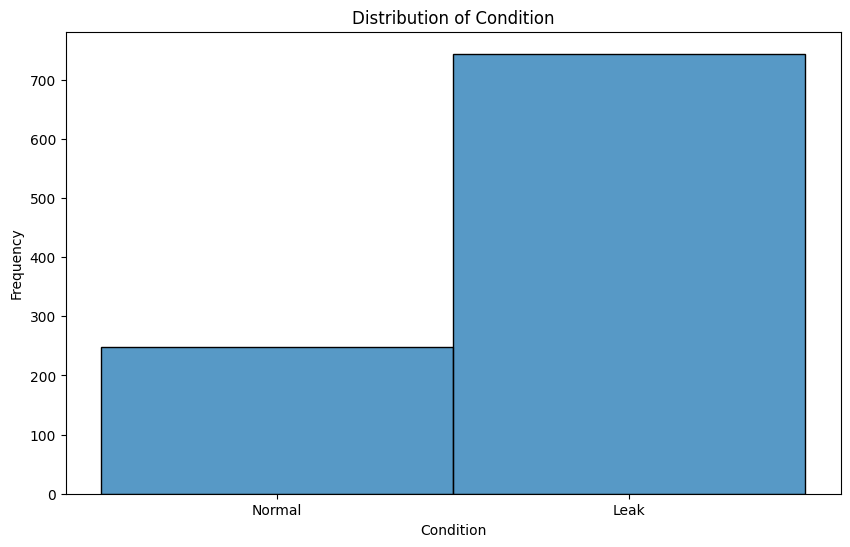

In [ ]:
data.isnull().sum()

# Unique values on categorical columns
print(data['Medium'].value_counts())
print(data['Condition'].value_counts())

from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data['Condition'], bins=20)
plt.title('Distribution of Condition')
plt.xlabel('Condition')
plt.ylabel('Frequency')
plt.show()

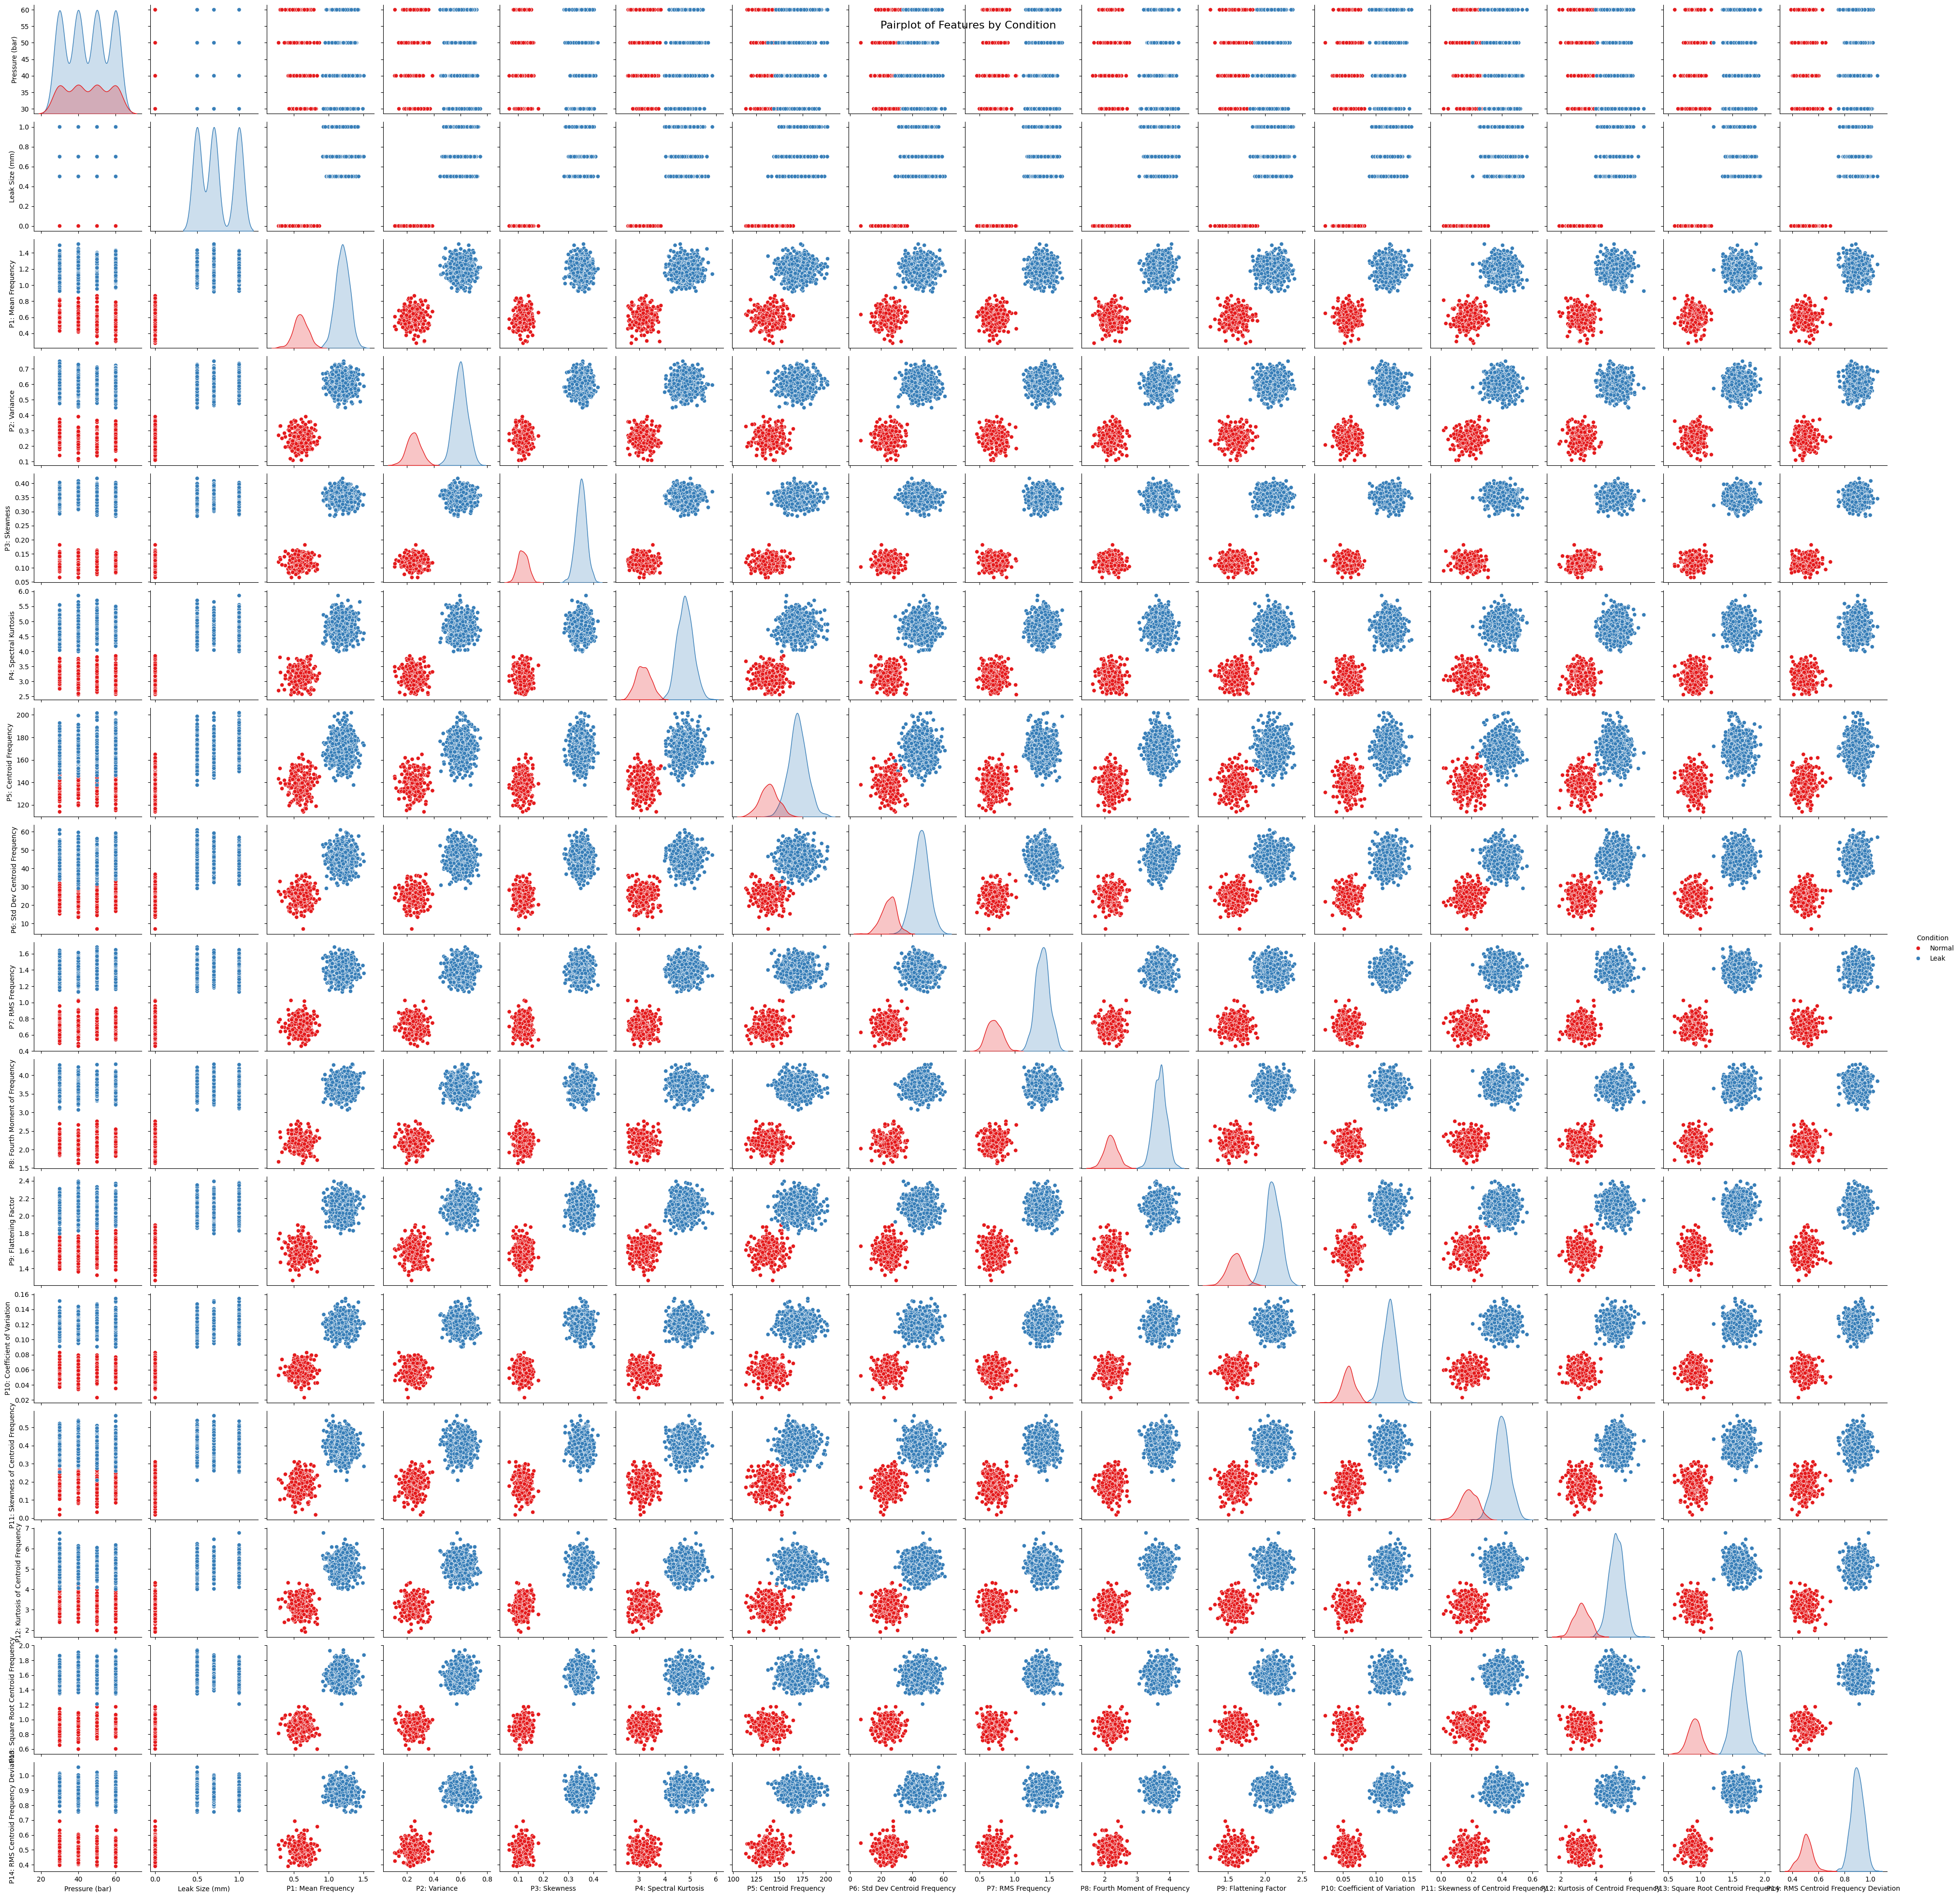

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(data, hue='Condition', palette='Set1')
plt.suptitle('Pairplot of Features by Condition', fontsize=16)

plt.show()

# Correlation - All columns exhibit a high degree of correlation with one another.
# So which column to use?

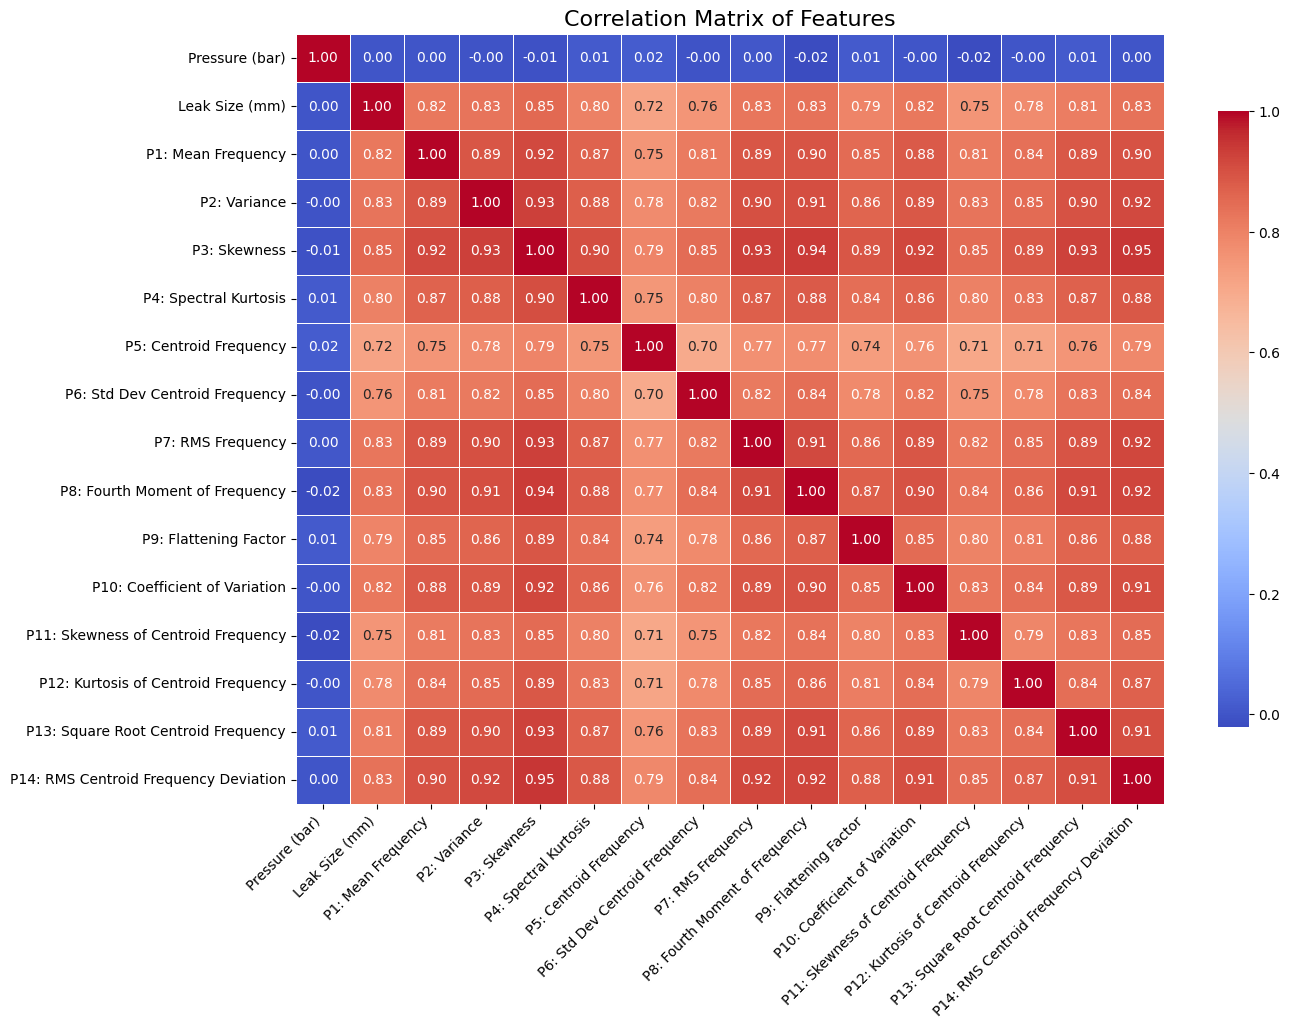

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

sns.heatmap(
    data.drop(columns=['Medium', 'Condition']).corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 10},
    cbar_kws={"shrink": 0.8}
)

plt.title('Correlation Matrix of Features', fontsize=16)
plt.xticks(rotation=45, fontsize=10, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0, fontsize=10)  # Rotate y-axis labels

plt.show()

[6.66650524e-01 2.45802220e-01 8.61102464e-02 8.96608783e-04
 2.44968160e-04 1.20992233e-04 6.49207763e-05 3.26546782e-05
 2.09296673e-05 1.96202874e-05 1.88120420e-05 6.69194002e-06
 5.09195569e-06 4.50859237e-06 1.00637853e-06 2.04035035e-07]
Top features contributing to PC1:
P5: Centroid Frequency                   0.889569
P6: Std Dev Centroid Frequency           0.451380
P12: Kurtosis of Centroid Frequency      0.040425
P4: Spectral Kurtosis                    0.033623
P8: Fourth Moment of Frequency           0.031058
Leak Size (mm)                           0.015288
P7: RMS Frequency                        0.014118
P13: Square Root Centroid Frequency      0.014105
P1: Mean Frequency                       0.012376
Pressure (bar)                           0.011715
P9: Flattening Factor                    0.010363
P14: RMS Centroid Frequency Deviation    0.008204
P2: Variance                             0.007261
P3: Skewness                             0.004744
P11: Skewness of Cent

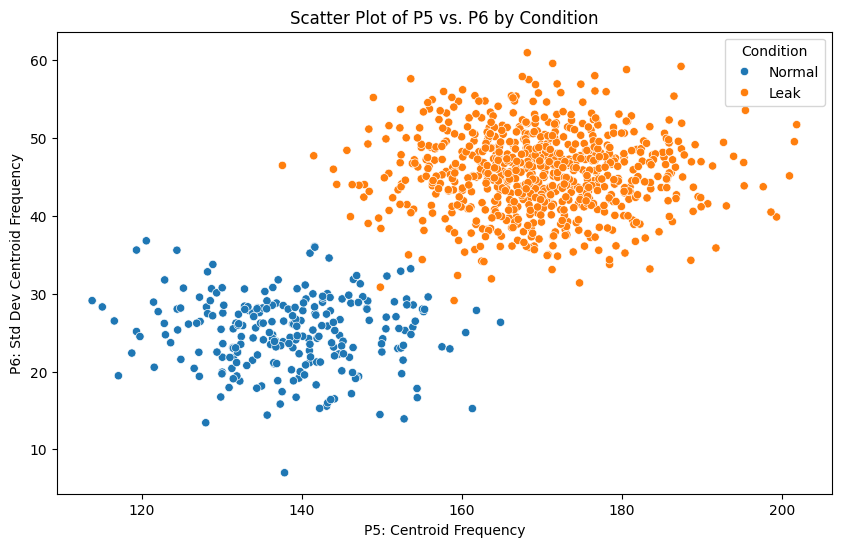

In [ ]:
# EDA - Feature Engineering - PCA
from sklearn.decomposition import PCA

# Determine how many n_components to use
pca = PCA().fit(X=data.drop(columns=['Medium', 'Condition']))
print(pca.explained_variance_ratio_)

feature_names = data.drop(columns=['Medium', 'Condition']).columns
components_df = pd.DataFrame(
    pca.components_,
    columns=feature_names,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)
print("Top features contributing to PC1:")
print(components_df.loc['PC1'].abs().sort_values(ascending=False))
print("\nTop features contributing to PC2:")
print(components_df.loc['PC2'].abs().sort_values(ascending=False))

X_pca = PCA(n_components=2).fit_transform(X=data.drop(columns=['Medium', 'Condition']))
pca_columns = [f"PC{i+1}" for i in range(X_pca.shape[1])]
pca_df = pd.DataFrame(X_pca, columns=pca_columns)

# Hybrid Approach:
# Use PCA to identify important patterns.
# - Select the top contributing features from PCA for further analysis or modeling.
# - This balances dimensionality reduction, interpretability, and domain relevance.

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x=data['P5: Centroid Frequency'], y=data['P6: Std Dev Centroid Frequency'], hue=data['Condition'])
plt.title('Scatter Plot of P5 vs. P6 by Condition')
plt.xlabel('P5: Centroid Frequency')
plt.ylabel('P6: Std Dev Centroid Frequency')
plt.legend(title='Condition')
plt.show()

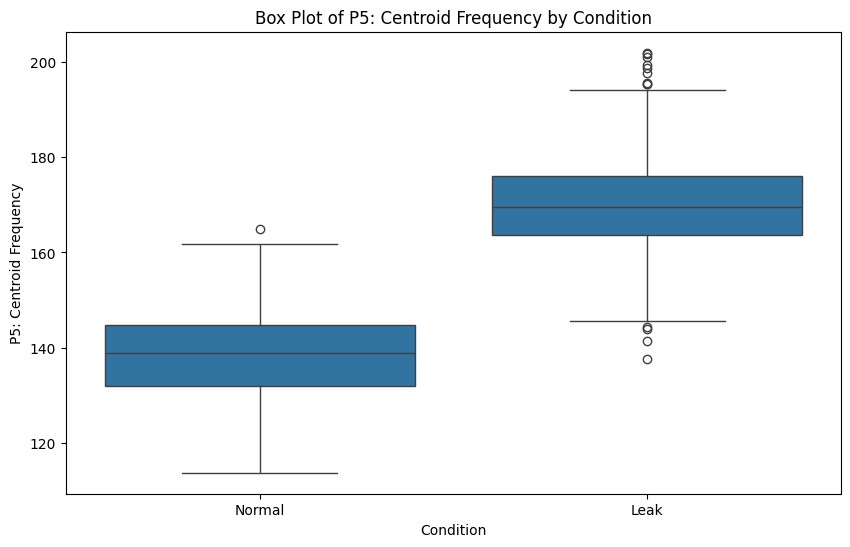

In [ ]:
# Still part of EDA
plt.figure(figsize=(10, 6))
sns.boxplot(x='Condition', y='P5: Centroid Frequency', data=data)
plt.title('Box Plot of P5: Centroid Frequency by Condition')
plt.xlabel('Condition')
plt.ylabel('P5: Centroid Frequency')
plt.show()

In [ ]:
# Standardizing data (Scaling/Encoding)
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

encoder = OrdinalEncoder(categories=[['Normal', 'Leak']])
data['Condition'] = encoder.fit_transform(data[['Condition']])
data['Condition'] = data['Condition'].astype(int)
data.head()

scaler = StandardScaler()
for columns in data.drop(columns=['Condition', 'Medium']).columns:
    data[columns] = scaler.fit_transform(data[[columns]])

data.head()

Pressure (bar) Medium  Leak Size (mm)  P1: Mean Frequency  P2: Variance  \
0       -1.341641    Oil       -1.510966           -1.428205     -1.688898   
1       -1.341641    Oil       -1.510966           -2.222346     -1.821673   
2       -1.341641    Oil       -1.510966           -1.820463     -1.736941   
3       -1.341641    Oil       -1.510966           -1.647099     -1.739888   
4       -1.341641    Oil       -1.510966           -1.905745     -1.742427   

   P3: Skewness  P4: Spectral Kurtosis  P5: Centroid Frequency  \
0     -1.567610              -0.957910               -1.463717   
1     -1.892887              -1.431625               -1.868346   
2     -1.812352              -0.828880               -1.331223   
3     -1.984110              -1.836879               -1.599711   
4     -1.629594              -1.172466               -1.610841   

   P6: Std Dev Centroid Frequency  P7: RMS Frequency  \
0                       -1.620805          -1.172184   
1                       -2.199446          -1.208262   
2                       -2.025293          -1.412571   
3                       -0.986620          -1.564722   
4                       -1.596996          -2.025361   

   P8: Fourth Moment of Frequency  P9: Flattening Factor  \
0                       -1.418911              -1.754249   
1                       -1.709878              -1.531192   
2                       -2.001389              -1.472485   
3                       -2.160228              -1.424626   
4                       -1.994171              -1.221740   

   P10: Coefficient of Variation  P11: Skewness of Centroid Frequency  \
0                      -1.375982                            -1.767430   
1                      -2.058983                            -1.805513   
2                      -2.244695                            -2.174188   
3                      -1.698037                            -1.867855   
4                      -1.093493                            -1.583325   

   P12: Kurtosis of Centroid Frequency  P13: Square Root Centroid Frequency  \
0                            -1.737884                            -1.584579   
1                            -1.497767                            -2.024434   
2                            -1.461983                            -1.427798   
3                            -1.289255                            -1.335425   
4                            -1.126087                            -1.546790   

   P14: RMS Centroid Frequency Deviation  Condition  
0                              -2.224205          0  
1                              -1.582169          0  
2                              -1.639481          0  
3                              -1.426333          0  
4                              -1.868498          0

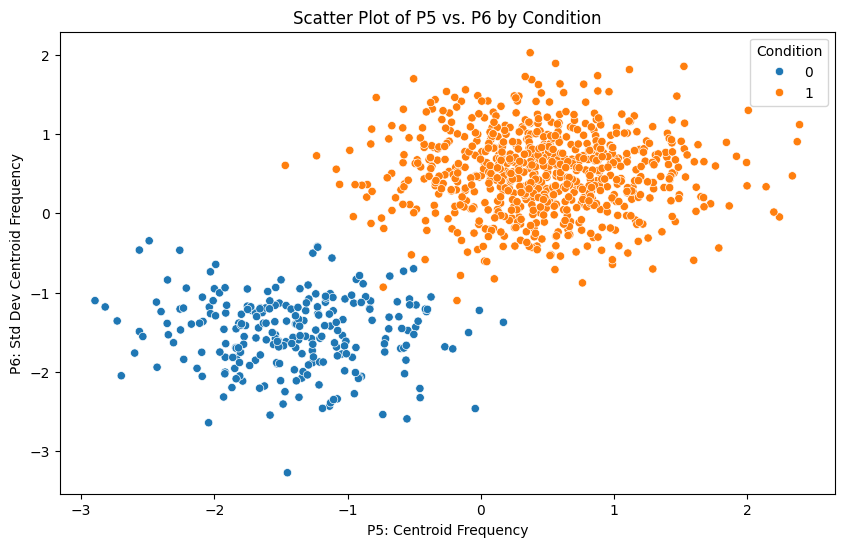

In [ ]:
# Visuals on features to use after scaling
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x=data['P5: Centroid Frequency'], y=data['P6: Std Dev Centroid Frequency'], hue=data['Condition'])
plt.title('Scatter Plot of P5 vs. P6 by Condition')
plt.xlabel('P5: Centroid Frequency')
plt.ylabel('P6: Std Dev Centroid Frequency')
plt.legend(title='Condition')
plt.show()

Condition
1    744
0    235
Name: count, dtype: int64


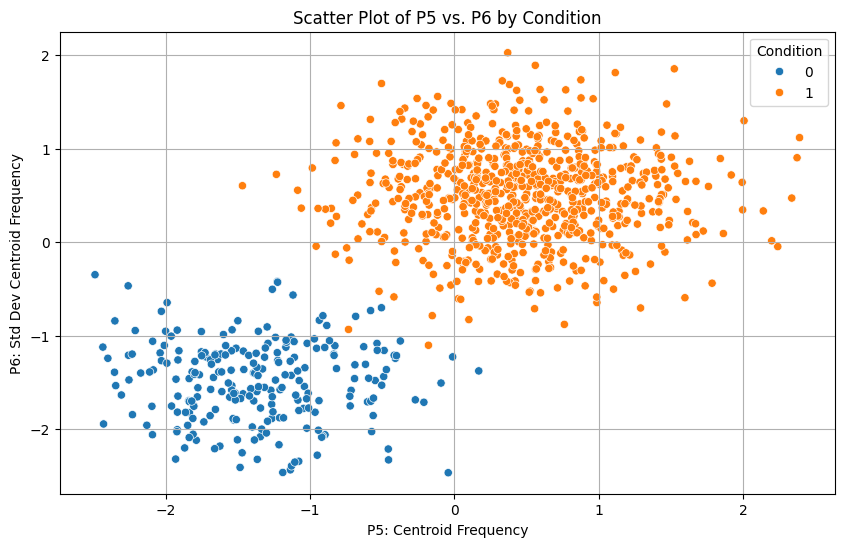

In [ ]:
data = RemoveOutliers(data, ['P5: Centroid Frequency', 'P6: Std Dev Centroid Frequency'])
print(data['Condition'].value_counts())

# Visualize the cleaned data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='P5: Centroid Frequency',
                y='P6: Std Dev Centroid Frequency',
                hue='Condition')
plt.title('Scatter Plot of P5 vs. P6 by Condition')
plt.xlabel('P5: Centroid Frequency')
plt.ylabel('P6: Std Dev Centroid Frequency')
plt.legend(title='Condition')
plt.grid()
plt.show()

# Modeling

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

data.drop(columns=['Medium'], inplace=True)
selected_columns = ['P5: Centroid Frequency', 'P6: Std Dev Centroid Frequency', 'Condition']
modeling_data = data.drop(columns=[c for c in data.columns if c not in selected_columns])
print(modeling_data.head())
X = modeling_data.drop(columns=['Condition'])
y = modeling_data['Condition']

   P5: Centroid Frequency  P6: Std Dev Centroid Frequency  Condition
0               -1.463717                       -1.620805          0
1               -1.868346                       -2.199446          0
2               -1.331223                       -2.025293          0
3               -1.599711                       -0.986620          0
4               -1.610841                       -1.596996          0


In [ ]:
# Regular split and single model use
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
# Evaluation
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.005708673469387756
R-squared: 0.9703442325895876


In [ ]:
# Using kFolds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in kf.split(X):
  X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
  y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

  rf.fit(X_train, y_train)
  y_pred = rf.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
avg_r2 = cross_val_score(rf, X, y, cv=kf, scoring='r2').mean()
print(f"Average R-squared: {avg_r2}")

Average R-squared: 0.9724323086019732


In [ ]:
# Multiple models with cross-validation
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Support Vector Machine": SVC(kernel='rbf', random_state=42),
}

# foreach Condition (cluster)
  # foreach Model
    # foreach k-folds
      # train, predict, and evaluate
        # Take average

X_super = data.drop(columns=['Condition'])
y_super = data['Condition']
r2_scores = []
mse_scores = []
cm_scores = []

for model_name, model in models.items():
  print("--------------------------------")
  print(model_name)
  cm = None
  for train_idx, test_idx in kf.split(X_super):

    X_train, X_test = X_super.iloc[train_idx], X_super.iloc[test_idx]
    y_train, y_test = y_super.iloc[train_idx], y_super.iloc[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test).astype(int)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    if cm is None:
      cm = confusion_matrix(y_test, y_pred)
    else:
      cm += confusion_matrix(y_test, y_pred)

    r2_scores.append(r2)
    mse_scores.append(mse)
    cm_scores.append(cm)

  avg_r2 = np.mean(r2_scores)
  avg_mse = np.mean(mse_scores)
  avg_cm = cm / kf.get_n_splits()
  print(f"Average R-squared: {np.mean(r2_scores)}")
  print(f"Average MSE: {np.mean(mse_scores)}")
  print(f"{avg_cm.astype(int)}")

--------------------------------
Random Forest
Average R-squared: 0.9602318840579709
Average MSE: 0.007142857142857143
[[ 47   0]
 [  1 147]]
--------------------------------
Logistic Regression
Average R-squared: 0.9801159420289854
Average MSE: 0.0035714285714285713
[[ 47   0]
 [  0 148]]
--------------------------------
Support Vector Machine
Average R-squared: 0.986743961352657
Average MSE: 0.0023809523809523807
[[ 47   0]
 [  0 148]]


# Conclusion
This project utilized a synthetic dataset derived from various scenarios to demonstrate key steps in data analysis and modeling. The primary objectives included:

- Conducting comprehensive Exploratory Data Analysis (EDA) to uncover patterns and relationships in the dataset.
- Implementing both regular train/test splits and k-fold cross-validation to evaluate model performance effectively.
- Comparing the performance of multiple machine learning models through cross-validation to identify the most suitable approach for the given task.
- The results highlighted the effectiveness of Random Forest and Logistic Regression for the classification task, while Support Vector Machines (SVM) required further optimization.

# Future Work
To further enhance this project and refine the models, the following tasks are proposed:

- Hyperparameter Tuning: Optimize model performance by systematically searching for the best hyperparameters using techniques like grid search or random search.
- Model Stacking: Explore ensemble techniques, such as stacking, to combine the strengths of multiple models and potentially improve overall predictive accuracy.